# Retrieving static geospatial data from a GraphQL query
##### Author: Kathryn Berger, August 2020


### Description

We are interested in retrieving two, static, geospatial layers from within our area of interest, the Rothamsted Research campus. In this example, we will retrieve both soil pH and soil invertebrate abundance from our GraphQL query. Using our results, we will run a linear regression to evaluate the relationship between soil pH and soil invertebrate abundance.


Examining our Data Sources within the __[Data Catalogue](https://app.agrimetrics.co.uk/catalog/data-sets)__, we see that these geospatial layers are available at 1km resolution. In this example, we will retrieve these static geospatial layers and convert them into a geospatial object (.shp file) to be used in any geographic information system (GIS).

### Importing requirements

In [1]:

options("Ncpus" = parallel::detectCores())

packages <- c("httr", "jsonlite", "lubridate", "rgdal", "sp", "tidyverse")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())), Ncpus=getOption("Ncpus", 1L), INSTALL_opts = '--no-lock', clean = TRUE)  
}

library(httr)
library(jsonlite)
library(lubridate)
library(rgdal)     
library(sp)
library(tidyverse)

Warning message:
"package 'jsonlite' was built under R version 4.0.2"
Warning message:
"package 'lubridate' was built under R version 4.0.2"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'rgdal' was built under R version 4.0.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.0.2"
rgdal: version: 1.5-12, (SVN revision 1018)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: C:/Users/kathryn.berger/Documents/R/R-4.0.1/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: C:/Users/kathryn.berger/Documents/R/R-4.0.1/library/rgdal/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_s

### Accessing the data from your geospatial GraphQL query

First, we will require a successful GraphQL query __[here](https://app.agrimetrics.co.uk/graph-explorer
)__ that includes the following: 
* A bounding box for the area of interest to be used as our ***geoFilter***
* For our geospatial query to work, we must have selected ***location*** options in our GraphQL query
* In this case, we have selected to retrieve the ***centroid*** values for each of the geospatialMeasure grid values as observed in the payload shown below
* An ***api-key*** of our own
* Depending on your subscription (trial vs. paid) amount of data available in this demo may vary 

In [2]:
options(stringsAsFactors = FALSE)

url = "https://api.agrimetrics.co.uk/graphql"
API_KEY <- Sys.getenv("API_KEY", "API_KEY")

# our query searches for soilPH and invertebrate count for area within defined polygon geospatial filter
# below we copy the payload from our GraphQL query using the Rothamsted bounding box for our geoFilter
# note the use added quotations used around the copied GraphQL query for reading into R
 
payload = '{"query":"query getFieldIdsNearLocation { geospatialMeasures(geoFilter: {location: {type: Polygon, coordinates: [[[-0.401073,51.80076],[-0.356222,51.80076],[-0.356222,51.819771],[-0.401073,51.819771],[-0.401073,51.80076]]]}}) { soilPH { unit value location { centroid } } soilTotalAbundanceOfInvertebrates { unit value location { centroid } } } } "}'

# you will need a subscription key first
# replace "api-key" with your own
r<-POST(url, body = payload, add_headers(.headers = c('Accept'="application/json",'Ocp-Apim-Subscription-Key'= API_KEY,'Content-Type'="application/json",'Accept-Encoding'="gzip, deflate, br")))

# reviewing the contents of the above query 
# if it has worked correctly you should see our two requested geospatialMeasures (soil PH and invertebrate abundance) below
str(httr::content(r, as = "parsed", type = "application/json"), max.level = 3)


List of 1
 $ data:List of 1
  ..$ geospatialMeasures:List of 2
  .. ..$ soilPH                           :List of 8
  .. ..$ soilTotalAbundanceOfInvertebrates:List of 8


### Converting our query output into a data frame 

In [3]:
# output of request into flattened json
get_data_text <- content(r, "text")
get_data_json <- jsonlite::fromJSON(get_data_text, flatten = TRUE)

# converting json to data frame
get_data_df <- as.data.frame(get_data_json)

# to examine a sample of our data frame  
head(get_data_df)


,data.geospatialMeasures.soilPH.unit,data.geospatialMeasures.soilPH.value,data.geospatialMeasures.soilPH.location.centroid.type,data.geospatialMeasures.soilPH.location.centroid.coordinates,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.unit,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.value,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.type,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.coordinates
,<chr>,<dbl>,<chr>,<list>,<chr>,<dbl>,<chr>,<list>
1,http://data.agrimetrics.co.uk/units/ph,6.068252,Point,"-0.3986048, 51.8092248",http://data.agrimetrics.co.uk/units/count,56.20854,Point,"-0.3986048, 51.8092248"
2,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,"-0.3844273, 51.8000391",http://data.agrimetrics.co.uk/units/count,30.71813,Point,"-0.3844273, 51.8000391"
3,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,"-0.384106, 51.809026",http://data.agrimetrics.co.uk/units/count,30.71813,Point,"-0.384106, 51.809026"
4,http://data.agrimetrics.co.uk/units/ph,7.231666,Point,"-0.3699316, 51.7998390",http://data.agrimetrics.co.uk/units/count,48.82695,Point,"-0.3699316, 51.7998390"
5,http://data.agrimetrics.co.uk/units/ph,8.210084,Point,"-0.3696074, 51.8088264",http://data.agrimetrics.co.uk/units/count,23.33654,Point,"-0.3696074, 51.8088264"
6,http://data.agrimetrics.co.uk/units/ph,6.044802,Point,"-0.355109, 51.808624",http://data.agrimetrics.co.uk/units/count,36.80287,Point,"-0.355109, 51.808624"


### Converting our first geospatialMeasure (soil pH)  into a spatial points data frame

Our data frame consists of two geospatialMeasures (soil pH and soil invertebrate abundance), each of which may have their own different spatial resolutions (and corresponding coordinates). Therefore, we must treat each geospatialMeasure separately. This means we will deal with each data frame one at a time.  

In this section, we will develop two ***SpatialPointsDataFrames*** and later ***shapefiles*** for both soil pH and soil invertebrate abundance, respectively. 
Below, we focus on soil pH first.

In [4]:
# we must extract the soil PH data from our dataframe, to do so we need to know which columns correspond 
# Using the section above to examine our headers, we subset the first four columns to focus on soil PH
soilph_data <-get_data_df[, 1:4]

# r has a problem with unseparated coordinates, so we fix it here, by separating them 
soilph_data <- soilph_data %>%
  mutate(point_lat = unlist(map(soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates,2)),
         point_long = unlist(map(soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates,1)))

# dropping coordinates column as it will cause confusion downstream
soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates <- NULL

# we assign an EPSG string for coordinates system latitude and longitude
latlong = "+init=epsg:4326"

# making a SpatialPointsDataFrame (spdf) object
soilph_spdf <- sp::SpatialPointsDataFrame(coords=soilph_data[, c("point_long", "point_lat")],
                                      data = soilph_data, 
                                      proj4string=CRS(as.character(latlong)))

# To produce a .shp file that can be used across a number of GIS platforms we convert the spdf object to a .shp file
# but ESRI shapefiles limit headers to 10 characters, so we must rename them here using our knowledge of the column headers
# using spdf 'data' slot we rename the column headers where required
colnames(soilph_spdf@data)[2] = "value"
colnames(soilph_spdf@data)[1] = "unit"
colnames(soilph_spdf@data)[3] = "type"

# and finally, we convert the spdf to ESRI shapefile named "soilph" which we save in our tempdir folder
rgdal::writeOGR(obj=soilph_spdf, dsn="tempdir", layer="soilph", driver="ESRI Shapefile", overwrite_layer=TRUE) 

### Working on our second geospatial layer of interest (soil invertebrate abundance)
 
Below, we focus on the second half of our data frame and develop a ***SpatialPointsDataFrames*** for our soil invertebrate abundance layer. Then we convert the ***SpatialPointsDataFrame*** into a ***shapefile*** that can be used across a variety of GIS tools. 

In [5]:
# we select columns 5-8 that contain the information corresponding to our soil invertebrate abundance layer
invertebrates_data <-get_data_df[, 5:8]

# r has a problem with unseparated coordinates so fixing it here
invertebrates_data <- invertebrates_data %>%
  mutate(point_lat = unlist(map(invertebrates_data$data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.coordinates,2)),
         point_long = unlist(map(invertebrates_data$data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.coordinates,1)))

# dropping coordinates column as it will cause confusion downstream
invertebrates_data$data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.coordinates <- NULL
#View(invertebrates_data)

# we assign an EPSG string for coordinates system latitude and longitude
latlong = "+init=epsg:4326"

# making a SpatialPointsDataFrame (spdf) object
invertebrates_data_spdf <- SpatialPointsDataFrame(coords=invertebrates_data[, c("point_long", "point_lat")],
                                      data = invertebrates_data, 
                                      proj4string=CRS(as.character(latlong)))

# To produce a .shp file that can be used across a number of GIS platforms we convert the spdf object to a .shp file
# but ESRI shapefiles limit headers to 10 characters, so we must rename them here using our knowledge of the column headers
# using spdf 'data' slot we rename the column headers where required
colnames(invertebrates_data_spdf@data)[2] = "value"
colnames(invertebrates_data_spdf@data)[1] = "unit"
colnames(invertebrates_data_spdf@data)[3] = "type"

# and finally, we convert the spdf to ESRI shapefile named "soilph" which we save in our tempdir folder
rgdal::writeOGR(obj=invertebrates_data_spdf, dsn="tempdir", layer="soil_invertebrates", driver="ESRI Shapefile", overwrite_layer=TRUE) 

### Results
 
We can visualise our results by plotting them using any GIS tool. The two shapefiles produced in this demo draw from the same 1km grid and so will have identical centroid coordinates meaning they will overlap if displayed at the same time. Below, we display our soil_invertebrates.shp file in QGIS using a standard basemap. 

In [ ]:
<img src="rothamsted_invertebrates_demo.png" />

### Linear regression analysis 

Using data retrieved from the exercise above, we will perform a linear regression to evaluation the relationship between soil pH and soil invertebrate abundance.


Call:
lm(formula = invertebrates_data_spdf$value ~ soilph_spdf$value)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.1881  -7.8865   0.4674   7.9924  20.5467 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)         105.31      59.84   1.760    0.129
soilph_spdf$value   -10.65       8.56  -1.244    0.260

Residual standard error: 15.53 on 6 degrees of freedom
Multiple R-squared:  0.2051,	Adjusted R-squared:  0.07266 
F-statistic: 1.548 on 1 and 6 DF,  p-value: 0.2598



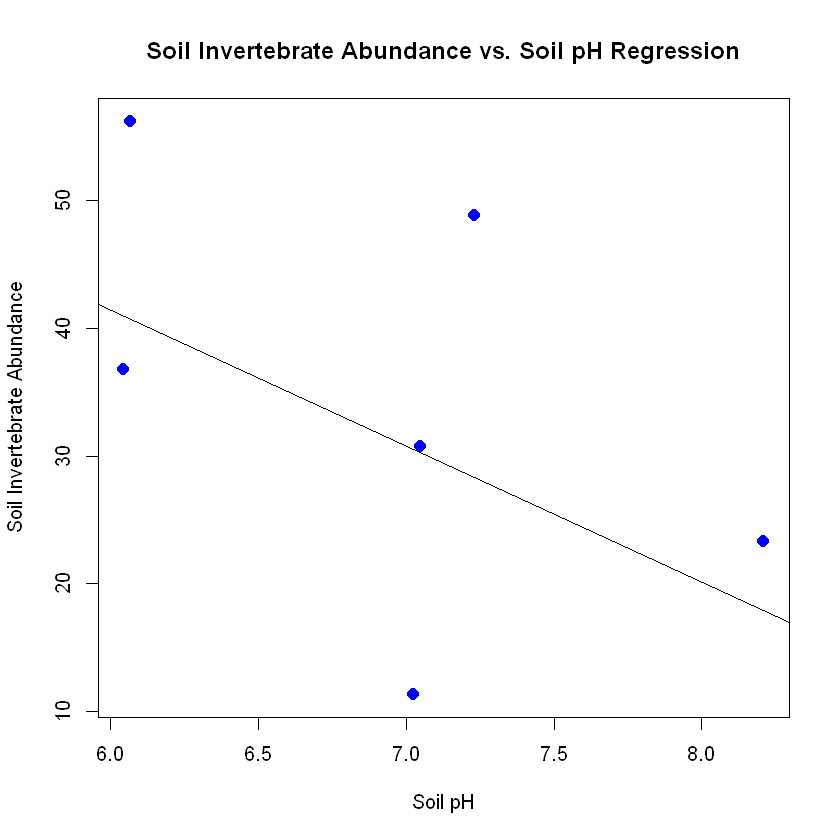

In [6]:
# performing a simple linear regression using the formula lm(y~x)
# where "x" is the independent variable
# in this example "soil pH" values, extracted from the soilph_spdf
# and "y" is the dependent variable
# in this example "soil invertebrate abundance" values, extracted from the invertebrates_data_spdf

results <- lm(invertebrates_data_spdf$value~soilph_spdf$value)

# printing the results summary of our linear regression analysis
print(summary(results))

# plotting our data points and best-fit line
plot(soilph_spdf$value, invertebrates_data_spdf$value, col = "blue",main = "Soil Invertebrate Abundance vs. Soil pH Regression",
abline(lm(invertebrates_data_spdf$value~soilph_spdf$value)), cex = 1.3, pch = 16, xlab = "Soil pH", ylab = "Soil Invertebrate Abundance")


The fitted line on our scatter plot suggests a negative relationship between soil pH and invertebrate abundance. However, when we examine the results of our linear regression we understand that the relationship is not statistically significant. 

### Conclusion
 
In this example, we have successfully retrieved static geospatial data from our GraphQL query and exported these data points into two separate shapefiles that can be used across a variety of GIS platforms and geospatial tools. We then performed a linear regression analysis using the values extracted from both spatial objects to better understand the relationship between soil invertebrate abundance and soil pH at our Rothamsted Research study area. 